In [168]:
import pandas as pd
import os
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [169]:
GOLD_DATA_PATH = os.path.join("..", "..", "data/gold/")
data_card_5_df = pd.read_csv(os.path.join(GOLD_DATA_PATH, "data_card_5_df.csv"), sep=";", encoding="latin1")


In [170]:
# data_card_5_df.set_index('Provincia', inplace=True)
consumo_df = data_card_5_df.drop(columns=['Potencia MWh'])
df = consumo_df

In [171]:
# Renombrar columnas para que coincidan con el formato esperado
df.columns = ['Provincia'] + [f'Consumo {año}' for año in range(2014, 2024)]

    # Preparar los datos para el modelo
    # Vamos a crear un DataFrame largo con todas las observaciones
datos_modelo = []

# Columnas de consumo (excluyendo 'Provincia')
columnas_consumo = [col for col in df.columns if col.startswith('Consumo')]

for provincia in df['Provincia']:
    # Obtener los consumos de cada provincia
    consumos = df[df['Provincia'] == provincia][columnas_consumo].values[0]
    
    # Crear características: provincia, año y consumo
    for i in range(len(consumos) - 1):
        fila = {
            'Provincia': provincia,
            'Año': 2014 + i,
            'Consumo_Actual': consumos[i],
            'Consumo_Siguiente': consumos[i+1]
        }
        datos_modelo.append(fila)

# Convertir a DataFrame
df_modelo = pd.DataFrame(datos_modelo)

# Codificar la provincia (one-hot encoding)
df_modelo_encoded = pd.get_dummies(df_modelo, columns=['Provincia'])

# Preparar características y objetivo
X = df_modelo_encoded.drop('Consumo_Siguiente', axis=1)
y = df_modelo_encoded['Consumo_Siguiente']

# Escalar características numéricas
scaler = StandardScaler()

# Identificar columnas numéricas para escalar
columnas_numericas = ['Año', 'Consumo_Actual']
X[columnas_numericas] = scaler.fit_transform(X[columnas_numericas])

# Dividir datos
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo Random Forest
rf_modelo = RandomForestRegressor(
    n_estimators=100,
    random_state=42,
    max_depth=None,
    min_samples_split=2
)
rf_modelo.fit(X_train, y_train)

# Evaluar modelo
predicciones_test = rf_modelo.predict(X_test)
mse = mean_squared_error(y_test, predicciones_test)
r2 = r2_score(y_test, predicciones_test)

# Preparar predicciones para 2028
predicciones_2028 = {}

for provincia in df['Provincia']:
    # Crear punto de predicción para 2028
    punto_2028 = X.iloc[-1:].copy()  # Usar la última fila como base
    
    # Actualizar año y consumo actual
    punto_2028['Año'] = 2027
    punto_2028['Consumo_Actual'] = df[df['Provincia'] == provincia][columnas_consumo].values[0][-1]
    
    # Restablecer columnas de provincia
    for col in [c for c in X.columns if c.startswith('Provincia_')]:
        punto_2028[col] = 0
    punto_2028[f'Provincia_{provincia}'] = 1
    
    # Escalar características numéricas
    punto_2028[columnas_numericas] = scaler.transform(punto_2028[columnas_numericas])
    
    # Predecir
    prediccion_2028 = rf_modelo.predict(punto_2028)[0]
    predicciones_2028[provincia] = prediccion_2028

# Predecir consumo para 2028
resultados = {
        'predicciones_2028': predicciones_2028,
        'error_cuadratico_medio': mse,
        'r2_score': r2,
    }

print("Predicciones de consumo para 2028:")
for provincia, consumo in resultados['predicciones_2028'].items():
    print(f"{provincia}: {consumo:.2f} MWh")

print("\nError Cuadrático Medio:", resultados['error_cuadratico_medio'])
print("R-squared Score:", resultados['r2_score'])


Predicciones de consumo para 2028:
Albacete: 477794.45 MWh
Ciudad Real: 750119.45 MWh
Cuenca: 216633.49 MWh
Guadalajara: 359641.04 MWh
Toledo: 1072736.60 MWh

Error Cuadrático Medio: 1536788787.8056002
R-squared Score: 0.9880446146265385


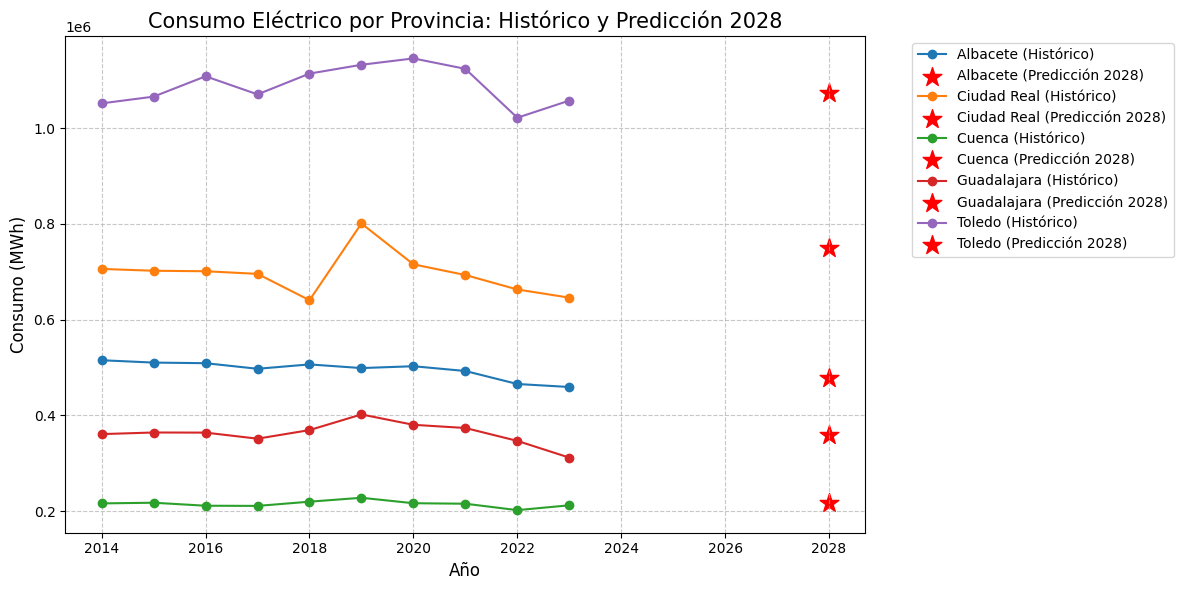

In [172]:
datos = df
predicciones_2028 = resultados['predicciones_2028']
plt.figure(figsize=(12, 6))

# Columnas de consumo
columnas_consumo = [col for col in datos.columns if col.startswith('Consumo')]

# Configurar estilo
plt.style.use('default')

# Graficar series históricas y predicciones
for provincia in datos['Provincia']:
    # Datos históricos
    consumos_historicos = datos[datos['Provincia'] == provincia][columnas_consumo].values[0]
    años_historicos = list(range(2014, 2024))
    
    # Graficar línea histórica
    plt.plot(años_historicos, consumos_historicos, marker='o', label=f'{provincia} (Histórico)')
    
    # Añadir punto de predicción para 2028
    plt.scatter(2028, predicciones_2028[provincia], marker='*', 
                color='red', s=200, 
                label=f'{provincia} (Predicción 2028)')

plt.title('Consumo Eléctrico por Provincia: Histórico y Predicción 2028', fontsize=15)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Consumo (MWh)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [178]:
placas = data_card_5_df['Potencia MWh']
placas_2028 = []
for i in range(len(placas)):
    placas_2028.append(placas[i]*predicciones_2028[data_card_5_df['Provincia'][i]])

print("Predicciones de placas para 2028:")
for i in range(len(placas)):
    print(f"{data_card_5_df['Provincia'][i]}: {placas_2028[i]:.2f} placas")
    
print("Total de placas necesarias en 2028 en Castilla La Mancha:", sum(placas_2028))
    

Predicciones de placas para 2028:
Albacete: 782793.34 placas
Ciudad Real: 1218352.42 placas
Cuenca: 348356.11 placas
Guadalajara: 560115.17 placas
Toledo: 1745802.07 placas
Total de placas necesarias en 2028 en Castilla La Mancha: 4655419.119090512
